In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In this notebook we build a model to forecast `US Wine Sales Volume (Mgal)`.

### Metrics
| Model | MAE | RSE | R-squared |
|:-------|-----|-----|-----------|
|Linear Regression (baseline)|16.515|469.123|0.694|
|Holt-Winters|**11.163**|**172.015**|**0.871**|
|Holt's Linear|14.935|366.339|0.743|
|ARIMA|15.933|445.255|0.613|
|DLM|17.464|494.047|0.695|

## Utils Functions

In [82]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
def split_dataset(data, test_size=0.2):
    data_sorted = data.sort_index()
    
    # Split the dataset
    train_data, test_data = train_test_split(data_sorted, test_size=test_size, shuffle=False)
    
    return train_data, test_data

In [4]:
def linear_interpolation(df, columns, window=None):
    df_ = df.copy()
    for col in columns:
        values_ = df_[col].values
        # Find the indices of known values
        known_indices = np.where(~np.isnan(values_))[0]
    
        # Interpolate between the first and last known values
        first_known_index = known_indices[0]
        if window:
            last_known_index = known_indices[min(first_known_index+window, len(known_indices)-1)]
        else:
            last_known_index = known_indices[-1]
    
        # Number of missing values to interpolate
        num_missing = last_known_index - first_known_index
    
        # Calculate the step between values
        step = (values_[last_known_index] - values_[first_known_index]) / (num_missing + 1)
    
        # Perform linear interpolation
        interpolated_values = []
        for i in range(0, first_known_index):
            interpolated_value = values_[first_known_index] - step * (first_known_index - i)
            interpolated_values.append(interpolated_value)
        
        values_[:first_known_index] = interpolated_values
        
        df_[col] = values_
    
    return df_

In [136]:
def stats_models_cv(model_name, data, params={}, n_folds=5):
    tscv = TimeSeriesSplit(n_splits=n_folds)
    # Initialize list of metrics
    mae_scores = []
    mse_scores = []
    r2_scores = []
    
    min_train_size = len(data)
    max_train_size = 0
    min_test_size = len(data)
    max_test_size = 0
    
    for train_idx, test_idx in tscv.split(data):
        # Split data into train and test sets
        train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
        
        # Record train and test sizes for stats
        min_train_size = min(min_train_size, len(train_data))
        max_train_size = max(max_train_size, len(train_data))
        min_test_size = min(min_test_size, len(test_data))
        max_test_size = max(max_test_size, len(test_data))
        
        # Initialize model
        if model_name == "holt-winters":
            # Select a value for seasonal periods
            default = max(2, len(train_data)//2)
            seasonal_periods = params.get("seasonal_periods", default)
            if seasonal_periods is None or seasonal_periods == "half":
                seasonal_periods = default
            elif seasonal_periods == "third":
                seasonal_periods = max(2, len(train_data)//3)
            
            # Initialize model
            model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
            # Fit model on training data
            model_fit = model.fit()
            # Forecast next steps
            forecast = model_fit.forecast(steps=len(test_data))
            actual = test_data
        elif model_name == "holt-linear":
            smoothing_level = params.get("smoothing_level", 0.9)
            smoothing_slope = params.get("smoothing_slope", 0.2)
            # Fit model
            model = Holt(train_data)
            model = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
            # Forecast next steps
            forecast = model.forecast(steps=len(test_data))
            actual = test_data
        elif model_name == "arima":
            p, d, q = params.get("p", 1), params.get("d", 1), params.get("q", 1)
            model = ARIMA(train_data, order=(p, d, q))
            # Fit model on training data
            model_fit = model.fit()
            # Forecast next steps
            forecast = model_fit.forecast(steps=len(test_data))
            actual = test_data
        elif model_name == "arimax":
            scale = params.get("scale", False)
            p, d, q = params.get("p", 1), params.get("d", 1), params.get("q", 1)
            X_train, y_train = train_data.iloc[:,:-1], train_data.iloc[:,-1]
            X_test, y_test = test_data.iloc[:,:-1], test_data.iloc[:,-1]
            if scale:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
            model = SARIMAX(y_train, exog=X_train, order=(p, d, q))
            model = model.fit()
            # Calculate metrics
            forecast = model.forecast(steps=len(test_data), exog=X_test)
            actual = y_test
        elif model_name == "dlm":
            discount = params.get("discount", 0.5)
            features_data = params.get("features_data", "linear")
            if features_data == "linear":
                components = trend(degree=1, discount=discount)
            else:
                components = dynamic(features=features_data, discount=discount)
            # Fit model on train data
            dlm_model = dlm(train_data.values)
            dlm_model = dlm_model + components
            dlm_model.fit()
            # Forecast the next steps
            forecast = dlm_model.predictN(N=len(test_data))[0]
            actual = test_data
        elif model_name == "lr":
            lr_model = Ridge()
            lr_model.fit(train_data.values[:,:-1], train_data.values[:,-1])
            # Predictions
            forecast = lr_model.predict(test_data.values[:,:-1])
            actual = test_data.values[:,-1]
        else:
            raise Exception(f"Model '{model_name}' is not supported")
        
        # Calculate metrics
        mae = mean_absolute_error(actual, forecast)
        mse = mean_squared_error(actual, forecast)
        r2 = r2_score(actual, forecast)
        
        # Append scores to lists
        mae_scores.append(mae)
        mse_scores.append(mse)
        r2_scores.append(r2)
    
    # Print average metrics across all folds
    print(f"Mean MAE: {np.mean(mae_scores)}")
    print(f"Mean MSE: {np.mean(mse_scores)}")
    print(f"Mean R-squared: {np.mean(r2_scores)}")
    print(f"Train sizes: min={min_train_size}, max={max_train_size}")
    print(f"Test sizes: min={min_test_size}, max={max_test_size}")

In [6]:
def calculate_correlation(dataframe):
    # Calculate correlation matrix for the given DataFrame
    correlation_matrix = dataframe.corr()
    return correlation_matrix

In [7]:
def visualize_correlation(correlation_matrix, figsize=(8,6)):
    # Visualize the correlation matrix using a heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)
    plt.title('Correlation Between Variables')
    #plt.xlabel('Time Series')
    #plt.ylabel('Time Series')
    plt.show()

## Load Data

In [8]:
data = pd.read_csv("forecast_data.csv")
data.shape

(24, 22)

In [9]:
columns = ["Year", "US Wine Production (Mgal)", "Median Income", "Num Seniors", "Num w/ small children", "US Wine Sales Volume (Mgal)"]

In [10]:
data = data[columns].copy()
data["Year"] = pd.to_datetime(data["Year"], format='%Y')
data = data.set_index("Year")
data.index.freq = 'AS-JAN' 
data = data.sort_index()
data.shape

(24, 5)

Fill missing values in other variables besides `US Wine Production (Mgal)`

In [11]:
data = linear_interpolation(data, columns=["US Wine Production (Mgal)"])

Target value is missing the last year

In [12]:
data = data[:-1]

In [13]:
def calculate_metrics(predicted, true):
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(true, predicted)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(true, predicted)
    
    # Calculate R-squared
    r_squared = r2_score(true, predicted)
    
    return mae, mse, r_squared

## Visualization and Correlations

<AxesSubplot:xlabel='Year', ylabel='US Wine Sales Volume (Mgal)'>

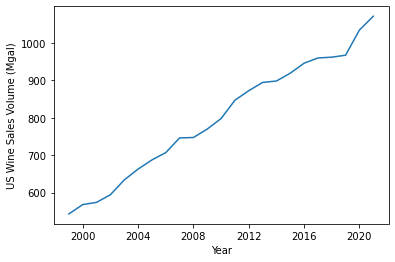

In [14]:
sns.lineplot(data=data, x=data.index, y="US Wine Sales Volume (Mgal)")

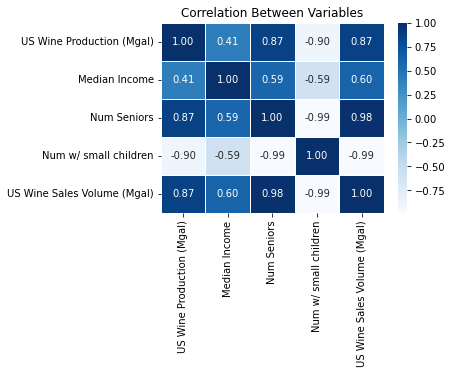

In [17]:
visualize_correlation(calculate_correlation(data), figsize=(5,3.5))

## Baseline

In [18]:
from sklearn.linear_model import Ridge, LinearRegression

In [19]:
baseline_data = data["US Wine Sales Volume (Mgal)"].copy()

In [20]:
baseline_data = baseline_data.reset_index()
baseline_data["Year"] = baseline_data["Year"].dt.year

In [21]:
baseline_train, baseline_test = split_dataset(baseline_data, test_size=0.2)
baseline_train.shape, baseline_test.shape

((18, 2), (5, 2))

In [22]:
ridge_reg = Ridge()
ridge_reg.fit(baseline_train.values[:,:-1], baseline_train.values[:,-1])

# Calculate metrics
baseline_preds = ridge_reg.predict(baseline_test.values[:,:-1])
baseline_mae, baseline_mse, baseline_r2 = calculate_metrics(baseline_preds, baseline_test.values[:,-1])
print(f"MAE: {baseline_mae:.5f}, MSE: {baseline_mse:.5f}, R-squared: {baseline_r2:.5f}")

MAE: 27.91816, MSE: 1165.06431, R-squared: 0.44033


<AxesSubplot:xlabel='Year', ylabel='US Wine Sales Volume (Mgal)'>

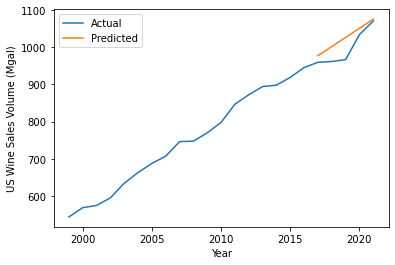

In [24]:
sns.lineplot(data=baseline_data, x="Year", y="US Wine Sales Volume (Mgal)", label="Actual")
sns.lineplot(x=baseline_test["Year"], y=baseline_preds, label="Predicted")

Cross-Validation

In [25]:
stats_models_cv(model_name="lr", data=baseline_data, n_folds=3)

Mean MAE: 16.515248260259767
Mean MSE: 496.1227357782782
Mean R-squared: 0.6943057474732764
Train sizes: min=8, max=18
Test sizes: min=5, max=5


## Statistical Models

In [120]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pydlm import dlm, dynamic, trend

In [27]:
target = ["US Wine Sales Volume (Mgal)"]

### Holt-Winters Exponential Smoothing

In [28]:
hw_data = data[target].copy()

In [29]:
hw_train, hw_test = split_dataset(hw_data, test_size=0.2)
hw_train.shape, hw_test.shape

((18, 1), (5, 1))

In [30]:
# Fit model
hw_model = ExponentialSmoothing(hw_train, trend='add', seasonal='add', seasonal_periods=9)
hw_model = hw_model.fit()

# Calculate metrics
forecast_hw = hw_model.forecast(steps=len(hw_test))
hw_mae, hw_mse, hw_r2 = calculate_metrics(forecast_hw, hw_test)
print(f"MAE: {hw_mae:.5f}, MSE: {hw_mse:.5f}, R-squared: {hw_r2:.5f}")

MAE: 14.12264, MSE: 215.69145, R-squared: 0.89639


<AxesSubplot:xlabel='Year', ylabel='US Wine Sales Volume (Mgal)'>

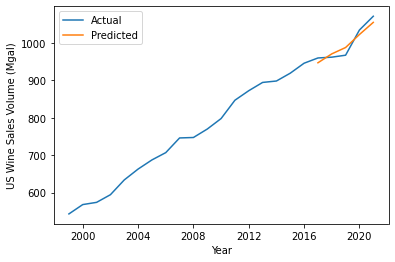

In [31]:
sns.lineplot(data=hw_data, x=data.index, y=target[0], label="Actual")
sns.lineplot(x=forecast_hw.index, y=forecast_hw.values, label="Predicted")

Cross-Validation

In [32]:
hw_params = {"seasonal_periods": "half"}
stats_models_cv(model_name="holt-winters", data=hw_data, params=hw_params, n_folds=3)

Mean MAE: 11.16387595034427
Mean MSE: 172.01472055466238
Mean R-squared: 0.872851916916131
Train sizes: min=8, max=18
Test sizes: min=5, max=5


### Holt's Linear Trend

In [143]:
# Fit model
hw_linear_model = Holt(hw_train)
hw_linear_model = hw_linear_model.fit(smoothing_level=0.5, smoothing_slope=0.2)

# Calculate metrics
forecast_hw_linear = hw_linear_model.forecast(steps=len(hw_test))
hwl_mae, hwl_mse, hwl_r2 = calculate_metrics(forecast_hw_linear, hw_test)
print(f"MAE: {hwl_mae:.5f}, MSE: {hwl_mse:.5f}, R-squared: {hwl_r2:.5f}")

MAE: 21.11138, MSE: 727.65931, R-squared: 0.65045


C:\Users\ngoum\AppData\Local\Temp\ipykernel_30572\573365988.py:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  hw_linear_model = hw_linear_model.fit(smoothing_level=0.5, smoothing_slope=0.2)
C:\Users\ngoum\anaconda3\envs\dl-env\lib\site-packages\pandas\util\_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


<AxesSubplot:xlabel='Year', ylabel='US Wine Sales Volume (Mgal)'>

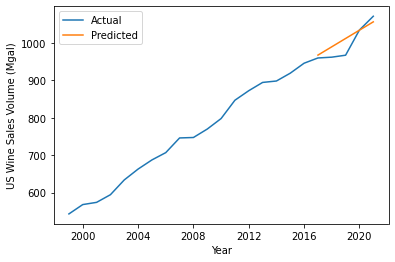

In [135]:
sns.lineplot(data=hw_data, x=data.index, y=target[0], label="Actual")
sns.lineplot(x=forecast_hw_linear.index, y=forecast_hw_linear.values, label="Predicted")

Cross-Validation

In [148]:
hw_params = {"smoothing_level": 0.5, "smoothing_slope": 0.2}
stats_models_cv(model_name="holt-linear", data=hw_data, params=hw_params, n_folds=3)

Mean MAE: 14.935489724470537
Mean MSE: 366.33958773837713
Mean R-squared: 0.7430842056128922
Train sizes: min=8, max=18
Test sizes: min=5, max=5


C:\Users\ngoum\AppData\Local\Temp\ipykernel_30572\286945043.py:45: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
C:\Users\ngoum\anaconda3\envs\dl-env\lib\site-packages\pandas\util\_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
C:\Users\ngoum\AppData\Local\Temp\ipykernel_30572\286945043.py:45: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
C:\Users\ngoum\anaconda3\envs\dl-env\lib\site-packages\pandas\util\_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
C:\Users\ngoum\AppData\Local\Temp\ipykernel_30572\286945043.py

### ARIMA

In [33]:
arima_data = data[target].copy()

In [34]:
arima_train, arima_test = split_dataset(arima_data, test_size=0.2)
arima_train.shape, hw_test.shape

((18, 1), (5, 1))

In [35]:
# Train model
p, d, q = 1, 2, 1
arima_model = ARIMA(arima_train, order=(p, d, q))
arima_model = arima_model.fit()

# Calculate metrics
forecast_arima = arima_model.forecast(steps=len(arima_test))
arima_mae, arima_mse, arima_r2 = calculate_metrics(forecast_arima, arima_test)
print(f"MAE: {arima_mae:.5f}, MSE: {arima_mse:.5f}, R-squared: {arima_r2:.5f}")

MAE: 20.78773, MSE: 727.42937, R-squared: 0.65056


<AxesSubplot:xlabel='Year', ylabel='US Wine Sales Volume (Mgal)'>

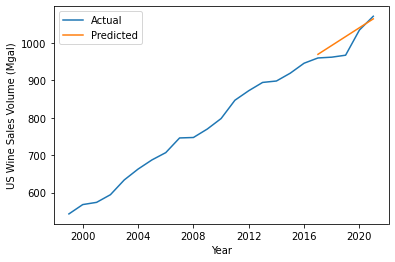

In [36]:
sns.lineplot(data=data, x=data.index, y=target[0], label="Actual")
sns.lineplot(x=forecast_arima.index, y=forecast_arima.values, label="Predicted")

Cross-Validation

In [66]:
arima_params = {"p": 1, "d": 2, "q": 1}
stats_models_cv(model_name="arima", data=arima_data, params=arima_params, n_folds=3)

Mean MAE: 15.932708140536882
Mean MSE: 445.2553627919119
Mean R-squared: 0.6135112341960911
Train sizes: min=8, max=18
Test sizes: min=5, max=5


### ARIMAX

In [61]:
arimax_features = ["US Wine Production (Mgal)", "Median Income", "Num Seniors", "Num w/ small children"]
arimax_target = ["US Wine Sales Volume (Mgal)"]

In [62]:
arimax_data = data[arimax_features + arimax_target].copy()

In [63]:
arimax_train, arimax_test = split_dataset(arimax_data, test_size=0.2)
arimax_train.shape, arimax_test.shape

((18, 5), (5, 5))

In [92]:
arimax_x_train, arimax_y_train = arimax_train.iloc[:,:-1], arimax_train.iloc[:,-1]
arimax_x_test, arimax_y_test = arimax_test.iloc[:,:-1], arimax_test.iloc[:,-1]

In [93]:
arima_scaler = StandardScaler()
arimax_x_train = arima_scaler.fit_transform(arimax_x_train)
arimax_x_test = arima_scaler.transform(arimax_x_test)

In [103]:
# Train ARIMAX model
p, d, q = 2, 1, 3
arimax_model = SARIMAX(arimax_y_train, exog=arimax_x_train, order=(p, d, q))
arimax_model = arimax_model.fit()

# Calculate metrics
arimax_forecast = arimax_model.forecast(steps=len(arimax_y_test), exog=arimax_x_test)
arimax_mae, arimax_mse, arimax_r2 = calculate_metrics(arimax_forecast, arimax_y_test)
print(f"MAE: {arimax_mae:.5f}, MSE: {arimax_mse:.5f}, R-squared: {arimax_r2:.5f}")

MAE: 26.65469, MSE: 1291.50298, R-squared: 0.37960


C:\Users\ngoum\anaconda3\envs\dl-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='Year', ylabel='US Wine Sales Volume (Mgal)'>

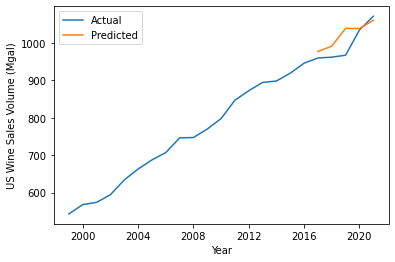

In [104]:
sns.lineplot(data=data, x=data.index, y=target[0], label="Actual")
sns.lineplot(x=arimax_forecast.index, y=arimax_forecast.values, label="Predicted")

Cross-Validation

In [119]:
arimax_params = {"p": 1, "d": 1, "q": 1, "scale": True}
stats_models_cv(model_name="arimax", data=arimax_data, params=arimax_params, n_folds=3)

Mean MAE: 345465922219076.25
Mean MSE: 5.650267699065725e+29
Mean R-squared: -3.9752532664872854e+26
Train sizes: min=8, max=18
Test sizes: min=5, max=5


C:\Users\ngoum\anaconda3\envs\dl-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ngoum\anaconda3\envs\dl-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### Dynamic Linear Models (DLM)

#### Without additional features
We assume a linearity of the data and we only use the target variable.

In [38]:
dlm_data = data[target].copy()

In [39]:
dlm_train, dlm_test = split_dataset(dlm_data, test_size=0.2)
dlm_train.shape, dlm_test.shape

((18, 1), (5, 1))

In [175]:
# Fit model on train data
dlm_model = dlm(dlm_train.values)
# Given the data is linear, we add a linear trend component
dlm_model = dlm_model + trend(degree=1, discount=0.4)
dlm_model.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


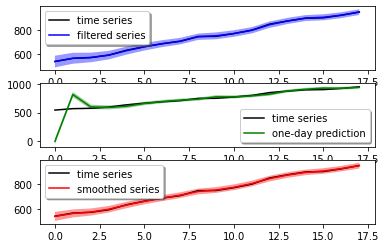

<Figure size 432x288 with 0 Axes>

In [273]:
dlm_model.plot()
plt.tight_layout()

In [177]:
# Forecast the next steps
forecast_dlm = dlm_model.predictN(N=len(dlm_test))[0]

In [178]:
dlm_mae, dlm_mse, dlm_r2 = calculate_metrics(forecast_dlm, dlm_test)
print(f"MAE: {dlm_mae:.5f}, MSE: {dlm_mse:.5f}, R-squared: {dlm_r2:.5f}")

MAE: 19.65068, MSE: 553.96476, R-squared: 0.73389


<AxesSubplot:xlabel='Year', ylabel='US Wine Sales Volume (Mgal)'>

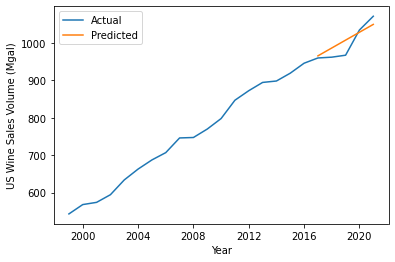

In [179]:
sns.lineplot(data=data, x=data.index, y=target[0], label="Actual")
sns.lineplot(x=dlm_test.index, y=forecast_dlm, label="Predicted")

Cross-validation

In [180]:
dlm_params = {"discount": 0.95, "features_data": "linear"}
stats_models_cv(model_name="dlm", data=dlm_data, params=dlm_params, n_folds=3)

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Mean MAE: 17.46366967554026
Mean MSE: 494.04710059031027
Mean R-squared: 0.6954987291194269
Train sizes: min=8, max=18
Test sizes: min=5, max=5


In [170]:
expanding_walk_forward_validation(lr_model, data[features + target].values, init_size=18)

Mean Absolute Error (MAE): 438.02388783092147
Mean Squared Error (MSE): 192773.52796521215
R-squared: 0.0
